# Transformation visuelle pour reconstruction d'image corporelle

## Objectifs
L'objectif est d'améliorer le code de network2_01.py. 
Plusieurs pistes d'amélioration sont possibles:
1. Utiliser un produit tensoriel plutôt qu'un produit terme à terme.
2. Différencier la cible de la main.
3. Intégerer tf.
4. changer la répartition des points. 

Je m'inspire de l'article de Memisevic, Gradient-based learning of higher-order image features et de son code gatedAutoencoder.py.

## Imports et setup





In [1]:
from numpy import *
from matplotlib.pylab import *
from mpl_toolkits.mplot3d import Axes3D
from drawnow import *
from skimage.draw import line, line_aa

import time 
import random
import scipy
import math
import cv2
import cPickle as pickle

import keras


Using TensorFlow backend.


In [2]:
matplotlib.rcParams.update({'font.size':16})
to_backup = True
timeframe = time.strftime('%Y%m%d%H%M%S')
L1 = 32
L2 = 16
L3 = 8

nb_posture = 30
nb_command = 10
nb_joint = 3
nb_data = nb_command*nb_posture
img_size = 128

## Construction de la base de données

1. On génère n postures différentes aléatoirement, X.
2. On génère m commandes aléatoirement, H. 
3. On applique chaque commande à chaque posture et on obtient des nouvelles postures Y.

### Génération des postures initiales

In [3]:
def randrange(n , vmin, vmax):
    return (vmax-vmin)*rand(n) + vmin 

In [4]:
posture = zeros((nb_posture, 3))
posture[:,0] = randrange(nb_posture, 0, pi)
posture[:,1] = randrange(nb_posture, 0, pi)
posture[:,2] =randrange(nb_posture, 0, pi)

In [5]:
print(shape(posture))
print(posture[0])

(30, 3)
[2.4133671  2.96701566 0.13842798]


### Génération des commandes 

In [6]:
command = zeros((nb_command, 3))
command[:,0] = randrange(nb_command, 0, 1)
command[:,1] = randrange(nb_command, 0, 1)
command[:,2] =randrange(nb_command, 0, 1)

In [7]:
print(shape(command))
print(command[0])
print(randint(0,nb_command-1))

(10, 3)
[0.09706473 0.27078623 0.4849155 ]
2


### Génération des données d'entraînement

In [8]:
train_data_x = zeros((nb_data, 1, 3))
train_data_y = zeros((nb_data, 1, 3))
train_data_h = zeros((nb_data, 1, 3))

In [9]:
print(train_data_x[0][0])
print(shape(train_data_x))

[0. 0. 0.]
(300, 1, 3)


In [10]:
idx = 0 
for i in range(nb_posture):
    for j in range(nb_command):
        train_data_x[idx] = posture[i]
        idx = idx + 1

idx = 0 
for i in range(nb_posture):
    for j in range(nb_command):
        train_data_y[idx] = posture[i]  + command[j]
        idx = idx + 1
        
idx = 0 
for i in range(nb_posture):
    for j in range(nb_command):
        train_data_h[idx] = command[j]
        idx = idx + 1

In [11]:
print('train_data_x 0 0 ', train_data_x[0][0])
print('train_data_h 0 0 ', train_data_h[0][0])
print('train_data_y 0 0 ', train_data_y[0][0])
print('y = x + h')

('train_data_x 0 0 ', array([2.4133671 , 2.96701566, 0.13842798]))
('train_data_h 0 0 ', array([0.09706473, 0.27078623, 0.4849155 ]))
('train_data_y 0 0 ', array([2.51043183, 3.23780189, 0.62334348]))
y = x + h


### Génération des images associées

In [12]:
train_images_x = zeros((nb_data, 1, 128, 128), dtype = uint8)
train_images_y = zeros((nb_data, 1, 128, 128), dtype = uint8)

In [13]:
for i in range(nb_data):
    img = zeros((img_size,img_size), dtype = uint8)
    angle = train_data_x[i][0] 
    row1, col1 = img_size//2 + int(floor(L1*sin(angle[0]))), img_size//2 + int(floor(L1*cos(angle[0])))
    row2, col2 =  int(floor(L2*sin(angle[1]))) + row1, col1 + int(floor(L2*cos(angle[1])))
    row3, col3 = int(floor(L3*sin(angle[2])))+ row2, col2 +  int(floor(L3*cos(angle[2])))
    r1, c1, val1 = line_aa(img_size//2,img_size//2,row1, col1)
    r2, c2, val2 = line_aa(row1, col1, row2, col2)
    r3, c3, val3 = line_aa(row2, col2, row3 , col3)
    img[r1,c1] = val1*255
    img[r2,c2] = val2*255
    img[r3,c3] = val3*255
    train_images_x[i][0] = img 

for i in range(nb_data):
    img = zeros((img_size,img_size), dtype = uint8)
    angle = train_data_y[i][0] 
    row1, col1 = img_size//2 + int(floor(L1*sin(angle[0]))), img_size//2 + int(floor(L1*cos(angle[0])))
    row2, col2 =  int(floor(L2*sin(angle[1]))) + row1, col1 + int(floor(L2*cos(angle[1])))
    row3, col3 = int(floor(L3*sin(angle[2])))+ row2, col2 +  int(floor(L3*cos(angle[2])))
    r1, c1, val1 = line_aa(64,64,row1, col1)
    r2, c2, val2 = line_aa(row1, col1, row2, col2)
    r3, c3, val3 = line_aa(row2, col2, row3 , col3)
    img[r1,c1] = val1*255
    img[r2,c2] = val2*255
    img[r3,c3] = val3*255
    train_images_y[i][0] = img 

On peut rajouter une gaussienne au bout de l'effecteur pour le mettre en évidence
TODO

In [14]:

def makeGaussian(size, fwhm = 3, center=None):
    """ Make a square gaussian kernel.
    size is the length of a side of the square
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.
    """
    x = arange(0, size, 1, float)
    y = x[:,newaxis]
    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]    
    return exp(-4*log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)


### Exemples d'images

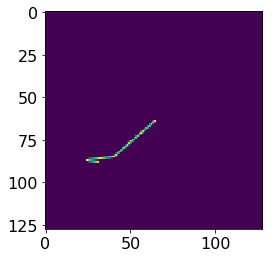

In [15]:
imshow(train_images_x[0][0])

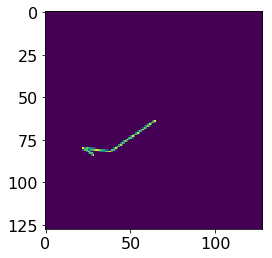

In [16]:
imshow(train_images_y[0][0])

## Factorized Gated Field Auto-encoder

Avant le passge dans l'autoencodeur, les images sont factorisées en passant par une couche de percpetron. De même, la couche latente est factorisée.
Les images sont de taille (128,128), on prend pour commencer 32 neurones. 
La sortie est de taille (3,1) (trois moteurs), on prend pour commencer une factorisation de taille (32,1) (synérgies motrices).

On a donc un encodeur, un décodeur et 3 couches de perceptrons pour les deux images et pour les commandes motrices.

On commence par construire un auto encodeur dont les entrées sont un tenseur de taille (32,1) et de sortie (32,1), pour garder la symétrie de la structure.


In [17]:
from keras.models import Model
from keras.layers import Activation, Dense, Input, Multiply
from keras.layers import Conv2D, Flatten, Reshape
from keras.layers import Dot, Lambda, Concatenate, RepeatVector
from keras import backend as K


### Création de l'encodeur 

In [18]:
input_size = 128
input_shape = (input_size, input_size, 2)
latent_dim = 30 # plus facile pour la concaténation des outputs...

# on donne en entrée des pairs d'images
inputs_xy = Input(shape = (128,128,2,), name = 'xy')

# on sépare chacune des images
x = Lambda(lambda x: x[:,:,:,0])(inputs_xy)
x = Reshape((128,128,1,))(x)

y = Lambda(lambda x: x[:,:,:,1])(inputs_xy)
y = Reshape((128,128,1,))(y)

print('taille initiale inputs_xy', K.int_shape(inputs_xy))
print('taille intiale de x', K.int_shape(x))
print('taille initiale de y', K.int_shape(y))

# on factorise chacune des images
fx = Flatten()(x)
fx = Dense(latent_dim, activation = 'relu', name = 'latent_fx')(fx)
fx = Reshape((latent_dim,1,))(fx)

fy = Flatten()(y)
fy = Dense(latent_dim, activation = 'relu', name = 'latent_fy')(fy)
fy = Reshape((latent_dim,1,))(fy)

# on multiplie les deux factorisations, TODO mieux si produit tensoriel
matmul = Multiply()([fx, fy])

print('taille inter fx', K.int_shape(fx))
print('taille inter fy', K.int_shape(fy))
print('taill inter matmul', K.int_shape(matmul))

# on passe le tout dans une couche de perceptrons pour obtenir les synérgies motrices
x = Flatten()(matmul)
fh = Dense(latent_dim, name = 'latent_fh')(x)
fh = Reshape((latent_dim,))(fh)

# on passe des synérgies motrices aux actionneurs
latent = Dense(3, activation = 'sigmoid',  name = 'latent_vector')(fh)
print('taille latent', K.int_shape(latent))


# tricks pour pouvoir passer fx et latent en outputs
fx = Reshape((1,latent_dim,))(fx)
latent = Reshape((1,3,))(latent)

out = Concatenate()([fx, latent])
print('out taille', K.int_shape(out))

encoder = Model(inputs = inputs_xy, outputs = out, name = 'encoder')
encoder.summary()

('taille initiale inputs_xy', (None, 128, 128, 2))
('taille intiale de x', (None, 128, 128, 1))
('taille initiale de y', (None, 128, 128, 1))
Instructions for updating:
Colocations handled automatically by placer.
('taille inter fx', (None, 30, 1))
('taille inter fy', (None, 30, 1))
('taill inter matmul', (None, 30, 1))
('taille latent', (None, 3))
('out taille', (None, 1, 33))
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
xy (InputLayer)                 (None, 128, 128, 2)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128)     0           xy[0][0]                         
__________________________________________________________________________________________________
lambda_2 (Lambda)        

### Création du décodeur

In [20]:
latent_inputs = Input(shape = (1,33,), name = 'decoder_input')
print('taille input', K.int_shape(latent_inputs))

# on déballe la factorisation en x
fxdec = Lambda(lambda x: x[:,:,:30])(latent_inputs)
fxdec = Reshape((30,1,))(fxdec)
print('taille fx', K.int_shape(fxdec))

# on déballe les commandes motrices
inp = Lambda(lambda x: x[:,:,30:])(latent_inputs)
inp = Reshape((3,))(inp)
print('taille tmp', K.int_shape(inp))

# on fait passer les commandes motrices dans la couche de perceptrons
fhdec = Dense(30, name='latent_fhdec')(inp)
print('taille fhdec avant', K.int_shape(fhdec))
fhdec = Reshape((30,1,))(fhdec)
print('taille fhdec apres', K.int_shape(fhdec))

# on mutliplie les deux représentations
matmuldec = Multiply()([fxdec, fhdec])
print('taille matmuldec avant', K.int_shape(matmuldec))
matmuldec = Reshape((30,))(matmuldec)
print('taille matmuldec apres', K.int_shape(matmuldec))

# on en déduit une factorisation 
fydec = Dense(30, name = 'latent_fydec')(matmuldec)

# on déduit l'image de départ de cette factorisation
ydec = Dense(16384, activation = 'softmax', name = 'y_recon')(fydec)
ydec = Reshape((128,128,1,))(ydec)
print('taille img dec', K.int_shape(ydec))


decoder = Model(latent_inputs, outputs= ydec, name='decoder')
decoder.summary()




('taille input', (None, 1, 33))
('taille fx', (None, 30, 1))
('taille tmp', (None, 3))
('taille fhdec avant', (None, 30))
('taille fhdec apres', (None, 30, 1))
('taille matmuldec avant', (None, 30, 1))
('taille matmuldec apres', (None, 30))
('taille img dec', (None, 128, 128, 1))
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      (None, 1, 33)        0                                            
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 1, 3)         0           decoder_input[0][0]              
__________________________________________________________________________________________________
reshape_14 (Reshape)            (None, 3)            0           lambda_6[0][0]                   
__________________________

### Création de l'auto-encodeur

In [23]:
autoencoder = Model(inputs_xy, decoder(encoder(inputs_xy)), name = "autoencoder")
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xy (InputLayer)              (None, 128, 128, 2)       0         
_________________________________________________________________
encoder (Model)              (None, 1, 33)             984123    
_________________________________________________________________
decoder (Model)              (None, 128, 128, 1)       508954    
Total params: 1,493,077
Trainable params: 1,493,077
Non-trainable params: 0
_________________________________________________________________


In [24]:
from keras.utils import plot_model 
plot_model(encoder, to_file='encoder.png')
plot_model(decoder, to_file = 'decoder.png')
plot_model(autoencoder, to_file = 'auto_encoder.png')